In [1]:
import drjit as dr
import matplotlib.pyplot as plt
import mitsuba as mi

mi.set_variant("llvm_ad_spectral")

# Set these to false to debug values
dr.set_flag(dr.JitFlag.VCallRecord, False)
dr.set_flag(dr.JitFlag.LoopRecord, False)

In [2]:
import numpy as np

from enum import Enum
from typing import NamedTuple

from tmm_fast import coh_tmm

In [3]:
parameters_t = np.dtype([
    ("f_k", "f4"),
    ("n_k", "f4"),
    ("f_m", "f4"),
    ("n_m", "f4"),
    ("k_m", "c8"),
    ("f_a", "f4"),
    ("n_a", "f4"),
])

class Material(Enum):
    KERATIN = 1
    MELANIN_MEMBRANE = 2
    MELANIN_INTERNAL = 3
    AIR = 4

def cauchy(A, B, wavelengths):
    return A + B*wavelengths**-2

def melanin_imaginary(wavelengths):
    a_m = 0.56
    b_m = 270
    return a_m * np.exp(-wavelengths / b_m) * 1.0j

def keratin_index(wavelengths):
    A_k = 1.532
    B_k = 5890
    return cauchy(A_k, B_k, wavelengths)

def melanin_index(wavelengths):
    A_m = 1.648
    B_m = 23700
    return cauchy(A_m, B_m, wavelengths)

def calc_keratin_layer(wavelengths):
    parameters = np.zeros(wavelengths.shape, dtype=parameters_t)
    parameters["f_k"] = 1
    parameters["n_k"] = keratin_index(wavelengths)
    parameters["f_m"] = 0
    parameters["n_m"] = 0
    parameters["k_m"] = 0
    parameters["f_a"] = 0
    parameters["n_a"] = 0
    return parameters

def calc_melanin_layer(wavelengths):
    parameters = np.zeros(wavelengths.shape, dtype=parameters_t)
    parameters["f_k"] = 0
    parameters["n_k"] = 0
    parameters["f_m"] = 1
    parameters["n_m"] = melanin_index(wavelengths)
    parameters["k_m"] = melanin_imaginary(wavelengths)
    parameters["f_a"] = 0
    parameters["n_a"] = 0
    return parameters

def calc_melanosome_internal_layer_index(wavelengths):
    parameters = np.zeros(wavelengths.shape, dtype=parameters_t)
    parameters["f_k"] = 0.05
    parameters["n_k"] = keratin_index(wavelengths)
    parameters["f_m"] = 0.4
    parameters["n_m"] = melanin_index(wavelengths)
    parameters["k_m"] = melanin_imaginary(wavelengths)
    parameters["f_a"] = 0.55
    parameters["n_a"] = 1
    return parameters

def calc_refractive_index(parameters):
    n_eff = (
        parameters["f_k"] * parameters["n_k"]
        + parameters["f_m"] * (parameters["n_m"] + parameters["k_m"])
        + parameters["f_a"] * parameters["n_a"]
    )

    return n_eff

def calc_layers(wavelengths):
    # Thicknesses in nm
    keratin_cortex_thickness = 5
    keratin_separation_thickness = 50
    melanosome_membrane_thickness = 30
    # Note: this can be changed to adjust periodicity
    melanosome_internal_thickness = 100
    top_melanosome_internal_thickness = 50

    air_layer_indices = np.ones(wavelengths.shape)
    keratin_layer_indices = calc_refractive_index(calc_keratin_layer(wavelengths))
    melanosome_membrane_indices = calc_refractive_index(calc_melanin_layer(wavelengths))
    melanosome_internal_indices = calc_refractive_index(calc_melanosome_internal_layer_index(wavelengths))

    # Init layers to first infinite air layer
    layers = [[Material.AIR, np.inf]]

    # Add keratin cortex layer
    layers.append([Material.KERATIN, keratin_cortex_thickness])

    # Add top melanosome layer
    layers.append([Material.MELANIN_MEMBRANE, melanosome_membrane_thickness])
    layers.append([Material.MELANIN_INTERNAL, top_melanosome_internal_thickness])
    layers.append([Material.MELANIN_MEMBRANE, melanosome_membrane_thickness])

    # Add the rest of the keratin separation and melanosome layers
    melanosome_layers = 12
    melanosome_layers -= 1  # Because of the top melanosome layer
    for _ in range(melanosome_layers):
        layers.append([Material.KERATIN, keratin_separation_thickness])
        layers.append([Material.MELANIN_MEMBRANE, melanosome_membrane_thickness])
        layers.append([Material.MELANIN_INTERNAL, melanosome_internal_thickness])
        layers.append([Material.MELANIN_MEMBRANE, melanosome_membrane_thickness])

    # Add keratin cortex layer
    layers.append([Material.KERATIN, keratin_cortex_thickness])

    # Add last infinite air layer
    layers.append([Material.AIR, np.inf])

    layers = np.array(layers)

    layers_indices = np.empty((layers.shape[0], wavelengths.size), dtype=np.complex64)
    layers_indices[layers[:, 0] == Material.AIR] = air_layer_indices
    layers_indices[layers[:, 0] == Material.KERATIN] = keratin_layer_indices
    layers_indices[layers[:, 0] == Material.MELANIN_MEMBRANE] = melanosome_membrane_indices
    layers_indices[layers[:, 0] == Material.MELANIN_INTERNAL] = melanosome_internal_indices

    return layers[:, 1].astype(np.float32), layers_indices

In [4]:
def get_dr_reflectance(wavelengths_total, thetas_total):
    wavelengths_total = dr.ravel(wavelengths_total).numpy()
    thetas_total = np.repeat(np.arccos(mi.Frame3f.cos_theta(thetas_total).numpy()), 4)
    results = []
    wavelength_count = wavelengths_total.size
    optimal_count = 100000
    divisor = wavelength_count // optimal_count
    step = wavelength_count // divisor
    for i in range(divisor):
        start = step * i
        end = step * (i + 1)

        if i == divisor - 1:
            end = wavelengths_total.size

        wavelengths = wavelengths_total[start:end]
        thetas = thetas_total[start:end]

        print(start, end)

        d_list, n_list = calc_layers(wavelengths)

        polarization = "s"
        O = coh_tmm(polarization, n_list, d_list, thetas, wavelengths, device="cpu")

        results.extend(O["R"].ravel())

    return dr.llvm.Array4f(np.reshape(results, (wavelength_count // 4, 4)))

In [5]:
@dr.wrap_ad(source='drjit', target='torch')
def torch_func(x):
    return x

In [6]:
class MyBSDF(mi.BSDF):
    def __init__(self, props):
        mi.BSDF.__init__(self, props)

        self.int_ior = mi.lookup_ior(props, "int_ior", "bk7")

        self.ext_ior = mi.lookup_ior(props, "ext_ior", "air")

        if self.int_ior < 0 or self.ext_ior < 0:
            raise ValueError("The interior and exterior indices of refraction must be positive!")

        self.eta = self.int_ior / self.ext_ior

        self.specular_reflectance = 1.0
        if props.has_property("specular_reflectance"):
            self.specular_reflectance: mi.Texture = props['specular_reflectance']
        self.specular_transmittance = 1.0
        if props.has_property("specular_transmittance"):
            self.specular_transmittance: mi.Texture = props['specular_transmittance']

        # Set the BSDF flags
        reflection_flags   = mi.BSDFFlags.DeltaReflection   | mi.BSDFFlags.FrontSide | mi.BSDFFlags.BackSide
        transmission_flags = mi.BSDFFlags.DeltaTransmission | mi.BSDFFlags.FrontSide | mi.BSDFFlags.BackSide | mi.BSDFFlags.NonSymmetric
        self.m_components  = [reflection_flags, transmission_flags]
        self.m_flags = reflection_flags | transmission_flags

    def sample(self, ctx, si, sample1, sample2, active):
        # reflectances = get_dr_reflectance(si.wavelengths, si.wi)

        has_reflection = ctx.is_enabled(mi.BSDFFlags.DeltaReflection, 0)
        has_transmission = ctx.is_enabled(mi.BSDFFlags.DeltaTransmission, 1)

        # Evaluate the Frensel equations for unpolarized illumination
        cos_theta_i = mi.Frame3f.cos_theta(si.wi)

        r_i, cos_theta_t, eta_it, eta_ti = mi.fresnel(cos_theta_i, self.eta)
        t_i = 1.0 - r_i

        bs = mi.BSDFSample3f()
        selected_r = mi.Mask()
        if has_reflection and has_transmission:
            selected_r = (sample1 <= r_i) & active
            bs.pdf = dr.detach(dr.select(selected_r, r_i, t_i))
        else:
            if has_reflection or has_transmission:
                selected_r = has_reflection & active
                bs.pdf = 1.0
            else:
                return bs, 0.0

        selected_t = ~selected_r & active

        bs.sampled_component = dr.select(selected_r, mi.UInt32(0), mi.UInt32(1))
        bs.sampled_type = dr.select(selected_r, mi.UInt32(+mi.BSDFFlags.DeltaReflection),
                                                mi.UInt32(+mi.BSDFFlags.DeltaTransmission))

        bs.wo = dr.select(selected_r,
                          mi.reflect(si.wi),
                          mi.refract(si.wi, cos_theta_t, eta_ti))

        bs.eta = dr.select(selected_r, 1.0, eta_it)

        reflectance = mi.unpolarized_spectrum(1.0)
        transmittance = mi.unpolarized_spectrum(1.0)
        if self.specular_reflectance and self.specular_reflectance != 1.0:
            reflectance = self.specular_reflectance.eval(si, selected_r)
        if self.specular_transmittance and self.specular_reflectance != 1.0:
            transmittance = self.specular_transmittance.eval(si, selected_t)

        value_r = mi.Spectrum(0.0)
        value_t = mi.Spectrum(0.0)

        if has_reflection and has_transmission:
            value_r = mi.Spectrum(1.0)
            value_t = mi.Spectrum(1.0)
        elif has_reflection:
            value_r = mi.Spectrum(r_i)
        elif has_transmission:
            value_t = mi.Spectrum(t_i)

        # print("reflectance", dr.shape(reflectance))

        value_r *= reflectance
        value_t *= transmittance

        # print("value_r", dr.shape(value_r))

        # For transmission, radiance must be scaled to account for the solid
        # angle compression that occurs when crossing the interface.
        factor = eta_ti if ctx.mode == mi.TransportMode.Radiance else 1.0
        value_t *= dr.sqr(factor)

        value: dr.llvm.ad.Array4f = dr.select(selected_r, value_r, value_t)

        v_tensor = dr.empty(mi.TensorXf, shape=dr.shape(value))
        v_tensor[0] = value.x
        v_tensor[1] = value.y
        v_tensor[2] = value.z
        v_tensor[3] = value.w
        res_tensor = torch_func(v_tensor)

        value = dr.unravel(dr.llvm.ad.Array4f, res_tensor)

        # value *= 0.5

        # value = dr.unravel(dr.llvm.ad.Array4f, torch_func(value.torch()))

        return bs, value

    def eval(self, ctx, si, wo, active):
        return 0.0

    def pdf(self, ctx, si, wo, active):
        return 0.0

    def eval_pdf(self, ctx, si, wo, active):
        return 0.0, 0.0

    def traverse(self, callback: mi.TraversalCallback):
        callback.put_parameter('eta', self.eta, +mi.ParamFlags.NonDifferentiable)
        if self.specular_reflectance:
            callback.put_object("specular_reflectance", self.specular_reflectance, +mi.ParamFlags.Differentiable)
        if self.specular_transmittance:
            callback.put_object("specular_transmittance", self.specular_transmittance, +mi.ParamFlags.Differentiable)

    def to_string(self):
        return (f'MyBSDF[\n'
                f'    eta={self.eta},\n'
                f']')

In [7]:
mi.register_bsdf("mybsdf", lambda props: MyBSDF(props))

In [8]:
scene = mi.load_file("matpreview/scene.xml")

In [9]:
img = mi.render(scene)

: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


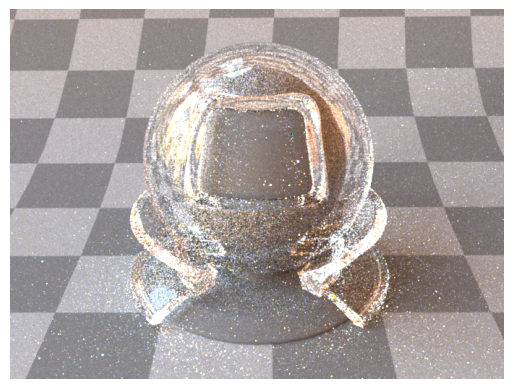

In [ ]:
plt.axis("off")
plt.imshow(img ** (1.0 / 2.2)) # approximate sRGB tonemapping